In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dataset.dataset import ComplexMorletWaveletTransform, Scalogram
from dataset.dataset import calculate_window_indices

In [2]:
ts = np.load('dataset/synthetic.npy')

In [3]:
window = 48
overlap = 44
window_indices = calculate_window_indices(
    len(ts), window, overlap
)
ts_sliced = np.array([ts[i:j] for i, j in window_indices])

In [4]:
from skopt import gp_minimize
from skopt.space import Real

class CWTParamTune:
    def __init__(self, time_series, window, overlap):
        self.window = window
        self.overlap = overlap
        self.window_indices = calculate_window_indices(
            len(time_series), window, overlap
        )
        self.time_series = time_series
        self.ts_sliced = np.array([time_series[i:j] for i, j in self.window_indices])
        self.scales = np.logspace(0.1, 2, num=window)
        self.lowest = np.inf
    
    def curve_gen(self, i, j):
        wavelet_transformer = ComplexMorletWaveletTransform(
            scales=self.scales,
            wavelet_params=(i, j),
            return_main=True,
            return_sub=True,
            decompose="magnitude_phase",
        )
        sequence_transformer = Scalogram(window=self.window, overlap=self.overlap, wavelet=wavelet_transformer)
        images = sequence_transformer.generate_scalograms(self.time_series)
        recon_sliced = []
        for image in images:
            recon_sliced.append(wavelet_transformer.inverse_transform(image[:,:,0], image[:,:,1]))
        recon_sliced = np.array(recon_sliced)
        return recon_sliced
    
    def mse(self, recon_sliced, ts_sliced):
        error = ((recon_sliced - ts_sliced) ** 2).mean(axis = 1).sum()
        return error
    
    def error_gen(self, params):
        # 解包传递的参数
        i, j = params
        recon_sliced = self.curve_gen(i, j)
        error = self.mse(recon_sliced, self.ts_sliced)
        if error < self.lowest:
            self.lowest = error
            print(f"New best params: i={i}, j={j}, error={error}")
        return error
    
    def tune(self):
        # 定义参数空间
        space = [Real(0.5, 2.0), Real(0.5, 2.0)]

        # 执行贝叶斯优化
        result = gp_minimize(self.error_gen, dimensions=space, n_calls=30, random_state=42)
        
        print(f"Best found parameters: i={result.x[0]}, j={result.x[1]} with minimum error: {result.fun}")

In [5]:
cwt = CWTParamTune(ts, 48, 44)
# cwt.tune()

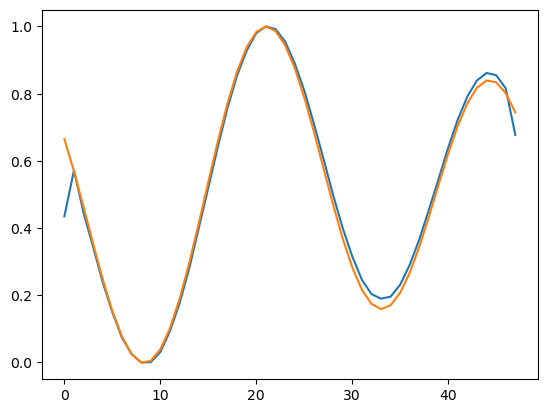

In [7]:
scales = np.logspace(0.1, 2, num=48)
wavelet_transformer = ComplexMorletWaveletTransform(
    scales=scales,
    wavelet_params=(1.5, 0.5),
    return_main=True,
    return_sub=True,
    decompose="magnitude_phase",
)
sequence_transformer = Scalogram(window=48, overlap=44, wavelet=wavelet_transformer)
images = sequence_transformer.generate_scalograms(ts)
plt.plot(wavelet_transformer.inverse_transform(images[0][:,:,0], images[0][:,:,1]))
plt.plot(cwt.ts_sliced[0])

In [11]:
images[0,:,:,0]

array([[-0.17916835, -0.20319584, -0.24237102, ..., -0.23664812,
        -0.24407406, -0.19844014],
       [-0.1763341 , -0.19704478, -0.23535384, ..., -0.23665933,
        -0.23899409, -0.19244978],
       [-0.17275715, -0.19515201, -0.2298428 , ..., -0.23860362,
        -0.22830715, -0.18285235],
       ...,
       [ 0.24132006,  0.24359134,  0.24564271, ...,  0.25884905,
         0.2561099 ,  0.26012868],
       [ 0.24036709,  0.24241355,  0.22983933, ...,  0.2519614 ,
         0.23658332,  0.25191438],
       [ 0.2314461 ,  0.23296168,  0.2178777 , ...,  0.24292731,
         0.22520197,  0.24257836]])